In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [3]:
from BHDVCStf import BHDVCS

In [4]:
bhdvcs = BHDVCS()

In [68]:
data = pd.read_csv('dvcs_psuedo.csv')

# For Set 0

Change the 

In [69]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [70]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [72]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

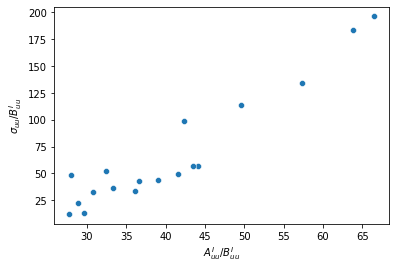

In [73]:
sns.scatterplot(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs))
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

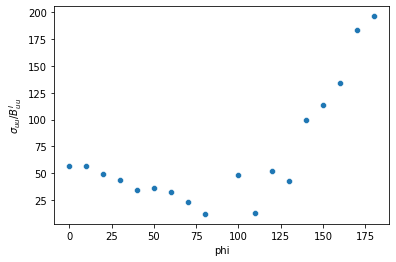

In [74]:
sns.scatterplot(x=data['phi_x'], y=produceLHS(data, bhdvcs))
plt.xlabel('phi')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

In [90]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
err = data['errF']

In [91]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [92]:
linear_curve_fit(X, 8, -46)

<tf.Tensor: shape=(18,), dtype=float64, numpy=
array([-19.74541845, -20.11710431, -21.15065984, -22.63614911,
       -24.31368279, -25.9463119 , -27.35681367, -28.4290657 ,
       -29.08990476, -28.96215351, -28.04678124, -26.44198449,
       -24.0317429 , -20.72816871, -16.60147856, -12.12824575,
        -8.42168874,  -6.94317843])>

In [93]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

### Fitted Compton Form Factors

In [94]:
cffs

array([  25.38852666, -112.84231885])

In [95]:
np.diag(var)

array([  9.33290576, 248.06637098])

### True CFFs

In [96]:
data.loc[0, ['ReH', 'ReE']]

ReH    13.0554
ReE   -53.0554
Name: 0, dtype: float64

In [82]:
yhat = linear_curve_fit(X, *cffs)

In [83]:
yhatwtrue = linear_curve_fit(X, 13.0554, -53.0554)

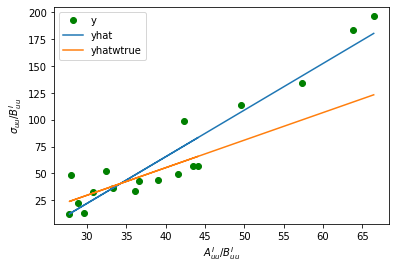

In [84]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## A/B vs phi

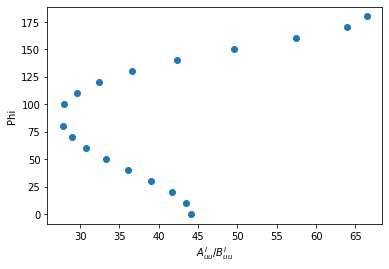

In [101]:
plt.scatter(aoverb(data, bhdvcs), data['phi_x'])
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('Phi')
plt.show()